In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from tqdm import tqdm
from pycocotools.coco import COCO

In [3]:
# Train GT json파일 불러오기
# 둘다 coco format 형식
train_gt_json = '/opt/ml/detection/dataset/train.json' 
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

In [4]:
'''
coco.getImgIds(): return image id list
    
coco.loadImgs(image_id): return image_info
    
image_info['file_name']: return file name
   
coco.getAnnIds(imgIds=image_info['id']): return annotation id
    
coco.loadAnns(ann_ids): return annotation information list (annotation_info_list)
    
annotation_info_list[i]['bbox']: return i'th annotation [x_min, y_min, w, h]
    
annotation_info_list[i]['category_id']: return i'th annotation category
    
'''
coco = COCO(train_gt_json)

def ToDataFrame(coco):
    gt = []
    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        annotation_id = coco.getAnnIds(img_id)
        annotation_info = coco.loadAnns(annotation_id)
        for an in annotation_info:
            x_min,y_min,w,h = an["bbox"][0],an["bbox"][1],an["bbox"][2],an["bbox"][3]
            image_id = an["category_id"]
            gt.append([file_name,image_id,float(x_min),(float(x_min) + float(w)), float(y_min),(float(y_min)+float(h))])
    GT_df = pd.DataFrame(gt,columns=["file_name","label","x_min","x_max","y_min","y_max"])
    return GT_df

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [5]:
df = ToDataFrame(coco)

label_dict = {}
for idx,name in enumerate(LABEL_NAME):
    label_dict[idx] = name

df["label"] = df["label"].apply(lambda x: label_dict[x])

In [6]:
df.to_csv('train_df.csv',index=False)

In [7]:
df['file_name'].value_counts().describe()

count    4883.000000
mean        4.739709
std         6.355155
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max        71.000000
Name: file_name, dtype: float64

/opt/conda/envs/detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


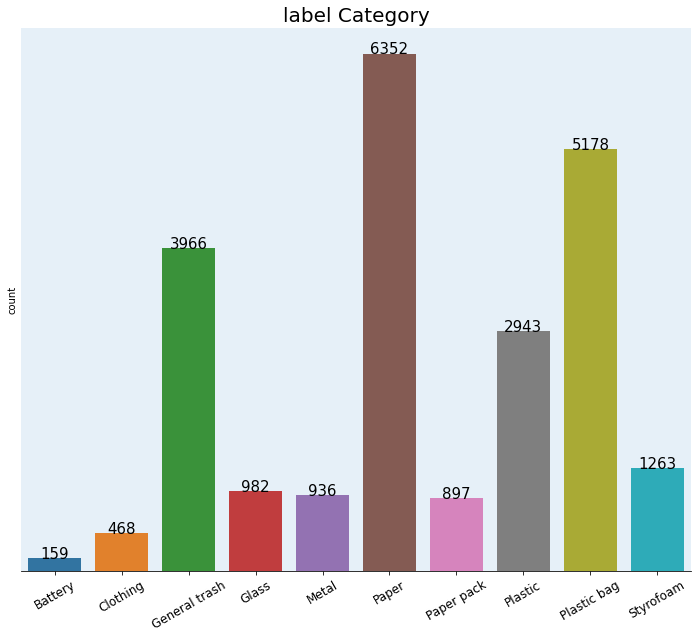

In [8]:
EDA_columns = ["label"]

def EDA(EDA_columns):
    plt.figure(figsize=(12,10))

    for i in range(len(EDA_columns)):
        ax = sns.countplot(sorted(df[EDA_columns[i]]))
        
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height, height,ha = 'center', size = 15)
        
        plt.title(EDA_columns[i] + " Category",size=20)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.yticks([])
        plt.xticks(rotation=30,size=12)
        plt.gca().set_facecolor('#E6F0F8')


EDA(EDA_columns)

/opt/conda/envs/detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


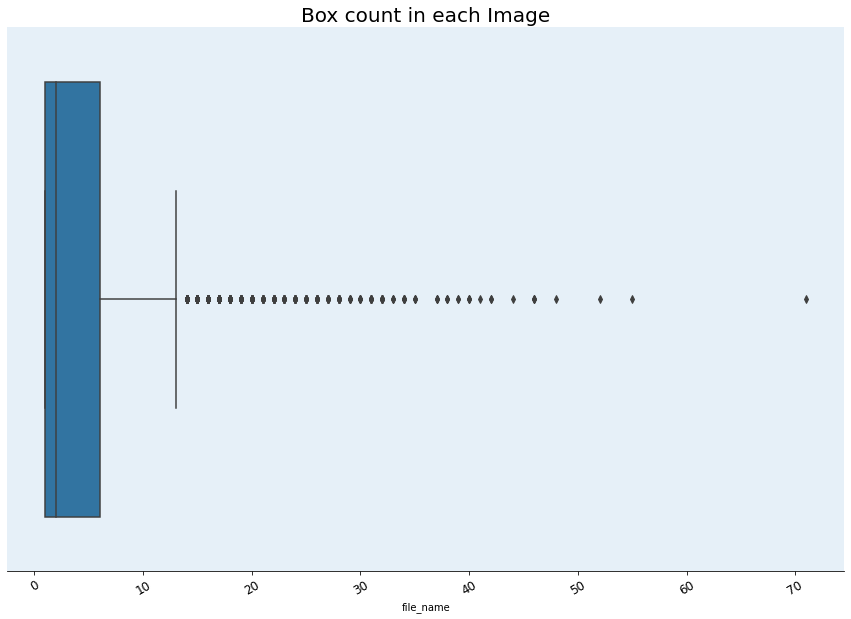

In [9]:
# box

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

ax = sns.boxplot(df["file_name"].value_counts())
plt.title("Box count in each Image",size=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
plt.xticks(rotation=30,size=12)
plt.gca().set_facecolor('#E6F0F8')

In [10]:
train_gt_json = '/opt/ml/detection/dataset/train.json' 
coco = COCO(train_gt_json)

def ToDataFrame(coco):
    gt = []
    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        annotation_id = coco.getAnnIds(img_id)
        annotation_info = coco.loadAnns(annotation_id)
        ps = ''
        for an in annotation_info:
            x_min,y_min,w,h = an["bbox"][0],an["bbox"][1],an["bbox"][2],an["bbox"][3]
            image_id = an["category_id"]
            ps += str(image_id) + ' ' + str(x_min) + ' ' + str(y_min) + ' ' + str(float(x_min) + float(w)) + ' ' + str(float(y_min)+float(h)) + ' '
        gt.append([file_name,ps])
    GT_df = pd.DataFrame(gt,columns=["image_id","PredictionString"])
    return GT_df
Gt = ToDataFrame(coco)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


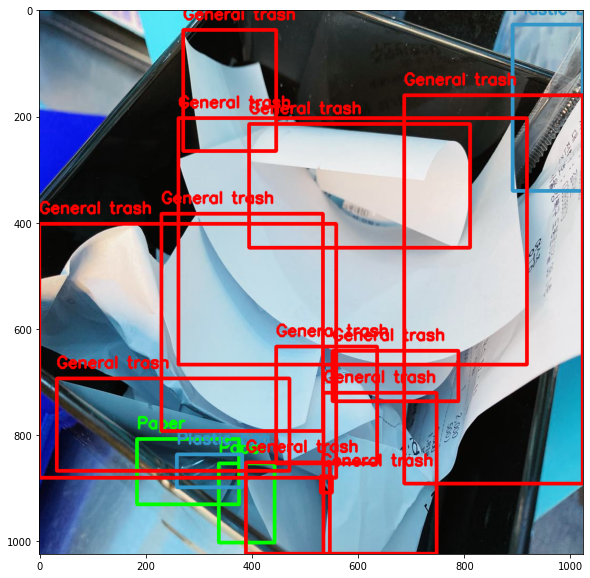

In [11]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt

# class 별 bbox 색
colors = [
    (255, 0, 0), 
    (0, 255, 0),
    (0, 0, 255),
    (127, 127, 0),
    (127, 0, 127),
    (0, 127, 127),
    (200, 200, 200),
    (50, 150, 200),
    (200, 155, 50),
    (130, 198, 20),
]
labels = {0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}

# 이미지 경로
img_dir = '/opt/ml/detection/dataset/'

test_result = Gt

file_names = test_result['image_id'].values.tolist()
bboxes = test_result['PredictionString'].values.tolist()

idx = random.choice(range(len(file_names)))
idx = 55
file_name = file_names[idx]
bbox = bboxes[idx].split()

image = cv2.imread(os.path.join(img_dir, file_name)).astype(np.uint8)
for i in range(0, len(bbox), 5):
    label = int(bbox[i])
    x_min = int(bbox[i + 1].split('.')[0])
    y_min = int(bbox[i + 2].split('.')[0])
    x_max = int(bbox[i + 3].split('.')[0])
    y_max = int(bbox[i + 4].split('.')[0])
    
    # bounding box 그리기
    image = cv2.rectangle(image, pt1=(x_min, y_min), pt2=(x_max, y_max), color=colors[label], thickness=5)
    # label text 넣기
    cv2.putText(image, labels[label], (x_min, y_min - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label], 3)

plt.figure(figsize=(10,10))
plt.imshow(image)